# ***Topic Modelling with LatentDirichletAllocaation***

First of all, some details to understand this part of my study on the dataset:

What mainly interest me in this dataset is not just to predict in which class each review should has been classified. The real question that I am wondering while studying this dataset is: what specifically make an hotel good or not for a customers. In other words, what are the main topics that customers are talking about when they are satisfied or not with an hotel. Same when they are not satisfied.

Classify review that have already been rated by customers does not have a real interest for business, what could be interesting for an hotel or a company as booking.com or similar is knowing what are the things that customers mainly care about. On which element should we focus our attention and where should we invest more to be considered as a great hotel. How to ensure that our customers will have a great experience in our hotel...

There come Topic Modelling and the study below.

In [ ]:
import os
import sys
os.chdir('..')

if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from preprocessing import pipeline
from gensim.models.phrases import Phrases
import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/delaygues/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/delaygues/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/delaygues/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/delaygues/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# ***this cells does not need to be run again as the results are saved in the csv file***

In [3]:
dataset = pd.read_csv('data/cleaned_tripadvisor_reviews.csv', index_col=0)
dataset.head()

,Review,Rating,cleaned_text
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking get good deal sta...
1,ok nothing special charge diamond member hilto...,2,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,nice room 4 experience hotel monaco seattle go...
3,"unique, great stay, wonderful time hotel monac...",5,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay go seahawk game awesome ...


# ***bigram and trigram***

starting by some preprocessing used in the previous classifier model. on this study they may have more importance

In [4]:
words = [review.split() for review in dataset['cleaned_text']]

# Détecter et ajouter les bigrammes et trigrammes
bigram = Phrases(words, min_count=10)
trigram = Phrases(bigram[words])

for idx in range(len(words)):
    doc = words[idx]
    
    # Ajouter les bigrammes
    bigrams = [token for token in bigram[doc] if '_' in token]
    words[idx].extend(bigrams)
    
    # Ajouter les trigrammes
    trigrams = [token for token in trigram[bigram[doc]] if '_' in token]
    words[idx].extend(trigrams)

# Remplacez la colonne cleaned_text par la version mise à jour (si vous voulez garder les versions en liste)
dataset['cleaned_text'] = words

# Si vous préférez convertir les listes de mots de retour en chaînes :
dataset['cleaned_text'] = [' '.join(doc) for doc in words]

print(dataset.head())

                                              Review  Rating  \
0  nice hotel expensive parking got good deal sta...       4   
1  ok nothing special charge diamond member hilto...       2   
2  nice rooms not 4* experience hotel monaco seat...       3   
3  unique, great stay, wonderful time hotel monac...       5   
4  great stay great stay, went seahawk game aweso...       5   

                                        cleaned_text  
0  nice hotel expensive parking get good deal sta...  
1  ok nothing special charge diamond member hilto...  
2  nice room 4 experience hotel monaco seattle go...  
3  unique great stay wonderful time hotel monaco ...  
4  great stay great stay go seahawk game awesome ...  


# ***filtering datas depending of their apparition***
words that are very unlikely to happen does not interest us as it means that it does not concern the majority of people while words that happen to often will probably be too generic world and have no interest

In [5]:
from gensim.corpora import Dictionary

# Créer un dictionnaire à partir des documents
dictionary = Dictionary(words)
print('Number of unique words in initial documents:', len(dictionary))

# Filtrer les mots qui apparaissent dans moins de 10 documents ou dans plus de 30% des documents
dictionary.filter_extremes(no_below=10, no_above=0.3)
print('Number of unique words after removing rare and common words:', len(dictionary))


Number of unique words in initial documents: 84501
Number of unique words after removing rare and common words: 13359


# ***Applying the model***

I tested some parameters manually as well as some vectorizer but this simple model has quite good result compared to the others. I will not go further in the study of the parameters as it is not the main goal of this study.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# 1. Obtenez le vocabulaire filtré
filtered_vocab = list(dictionary.token2id.keys())

# 2. Passez ce vocabulaire à CountVectorizer
vectorizer = CountVectorizer(vocabulary=filtered_vocab, stop_words='english')

# Convertissez les listes de mots filtrés en textes pour la vectorisation
filtered_texts = [' '.join(review) for review in words]

# 3. Transformez les documents en une matrice document-terme
dtm = vectorizer.transform(filtered_texts)

# 4. Initialisez et entraînez le modèle LDA de scikit-learn
num_topics = 4  # Ajustez en fonction de votre besoin
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(dtm)


LatentDirichletAllocation(n_components=4, random_state=42)

In [7]:
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances

# Évaluez la perplexité du modèle
perplexity = lda_model.perplexity(dtm)
print(f'Perplexity: {perplexity}')

# Calculez la cohérence des topics
topics = lda_model.transform(dtm)
topics = normalize(topics, norm='l1')  # Normalisez les probabilités des topics
coherence_score = np.mean(pairwise_distances(topics, metric='cosine'))
print(f'Coherence Score: {coherence_score}')

Perplexity: 2875.1758056540593
Coherence Score: 0.5682579901439966


### ***observation:***

Perplexity and coherence are the metrics used to estimate the quality of LDA model.
here the perplexity is extremely high as we want it to be as low as possible so our model is far from perfect but the coherence is quite good and the model is quite fast to run.

In [8]:
for i, topic in enumerate(lda_model.components_):
    print(f"Topic #{i + 1}:")
    print([vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-15:]])
    print("\n")

# Ajoutez une colonne 'topic' à votre dataframe pour stocker les résultats du modèle LDA
dataset['topic'] = lda_model.transform(dtm).argmax(axis=1)

Topic #1:
['lot', 'want', 'beautiful', 'really', 'buffet', 'drink', 'water', 'bar', 'like', 'people', 'punta_cana', 'pool', 'food', 'resort', 'beach']


Topic #2:
['block', 'wonderful', 'city', 'excellent', 'price', 'highly_recommend', 'recommend', 'comfortable', 'walk_distance', 'small', 'street', 'area', 'staff_friendly', 'helpful', 'friendly']


Topic #3:
['want', 'pay', 'leave', 'food', 'book', 'pool', 'people', 'bad', 'come', 'ask', 'check', 'desk', 'tell', 'like', 'say']


Topic #4:
['bar', 'new_york', 'station', 'price', 'city', 'minute', 'area', 'book', 'really', 'excellent', 'floor', 'view', 'small', 'bathroom', 'bed']




### ***observation:***

here we have 4 topics that are quite well defined. each of them contains different words even if some words are present in different topic and first I would be interested to find the differnece between the 4 topic, understand to what their correspond in real life

# ***Topic analysis***

/Users/delaygues/opt/anaconda3/lib/python3.8/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


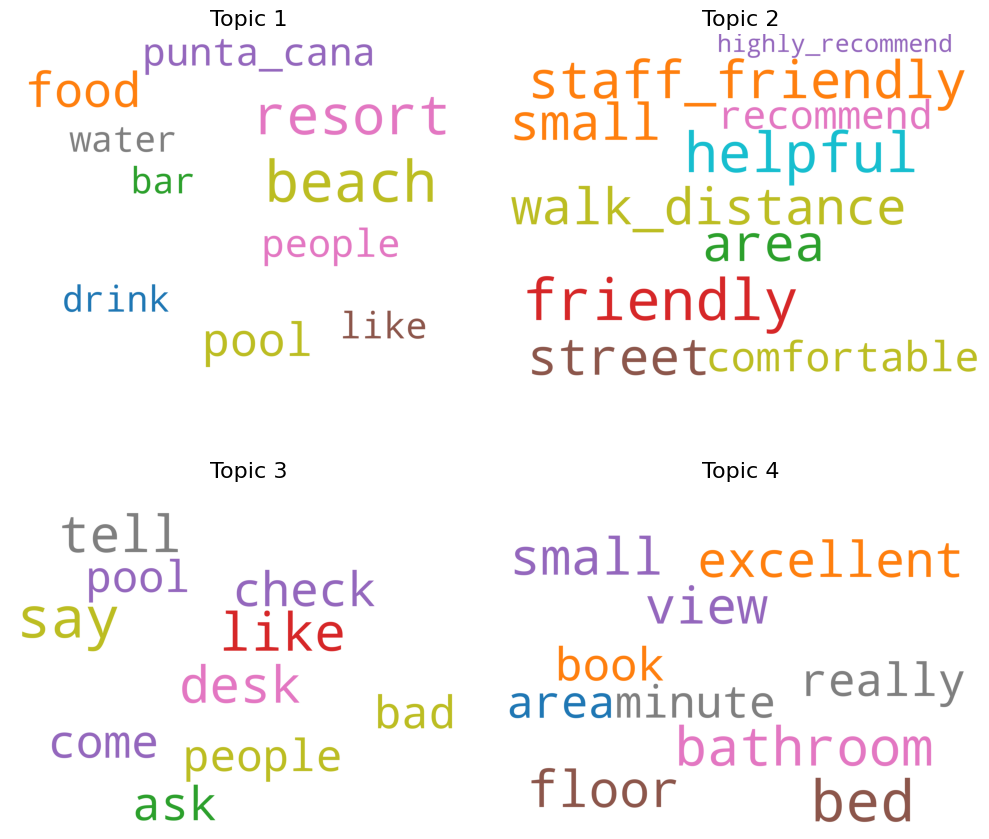

In [10]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

# Paramètres du wordcloud
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()] 
cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  prefer_horizontal=1.0)

# Création d'une liste pour stocker les mots clés de chaque sujet
topics_words = []

for topic in lda_model.components_:
    topic_word_indices = topic.argsort()[-10:]  # Je prends les 10 mots les plus pertinents pour chaque sujet
    words_for_topic = [vectorizer.get_feature_names_out()[index] for index in topic_word_indices]
    topic_weightage = {word: topic[index] for word, index in zip(words_for_topic, topic_word_indices)}
    topics_words.append(topic_weightage)

# Affichage des wordclouds
fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    cloud.generate_from_frequencies(topics_words[i], max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i + 1), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


### ***observation:***

while looking at these 4 topices we can try to understand how they were created:
- topic 1 is related to resort, "dream holidays hotel", all inclusive, ... this type of hotels (interesting to see the importance of bigram there with punta_cana) there the thingss that interest people is the beach, bar, food and the pool. 
- topic 2 is related to city hotel. there people are more focused about the location, the staff and the confort
- topic 3 is not really clear as it contains a lot of verbs that does not give insight ( we could have removed them ?) but an interesting thing is the fact that it is the only topic that cntains a negative word "bad"
- topic 4 really focus on the room. on this type of hotel we can clearly say that people are mainly interested about the quality of the room

# ***Use pyLDAvis for more insights***

this visualisation is often use with LDA

In [9]:
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.lda_model

pyLDAvis.enable_notebook()

# Préparez les données pour la visualisation
vis_data = pyLDAvis.lda_model.prepare(lda_model, dtm, vectorizer)
pyLDAvis.save_html(vis_data, 'visualisation.html')
# Affichez la visualisation
pyLDAvis.display(vis_data)

/Users/delaygues/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/delaygues/opt/anaconda3/lib/python3.8/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')
/Users/delaygues/opt/anaconda3/lib/python3.8/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')
/Users/delaygues/opt/anaconda3/lib/python3.8/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _

# ***observation:***

### ***the n° of topics are not the same than the previous plot"***

The left part shows the distance between different topics. the size of the circle indicate if lot of review are related to this topic. topic 1 and 3 that correspond to topic 2 and 4 of our precedent plot are really close to each others.

the right part show the top 30 terms by saliency. saliency measure the number of apparition of a words in the review bt also measure the apparation in this topic comparated  to the others topic: a words that appears a lot in this topic but not much in the others will have a high saliency. And it is an incredible insight for us to us as it allows us to measure the importance of a word for a category of hotel.

This way we can say that for each type of hotel that correspond to a particular topic. thy should focus on the words with high saliency. The more they considered them as part of a "topic" the more they have to focus on these subject. 

Adjust the parameter λ modify the weight of the distictiveness, and this is so usefull to establish our hotel type classes. with a low  λ  distinctuveness is high and then we clearly noitce that 1 and 3 are city hotel. 1 contain a lot of cities with a lot of offices and focus on the location comparated to the station and things like that so we can consider them as business hotel while 3 focus on touristic cities and touristic place so we can considere them as city trip hotel.

With this λ topic 4 confirm our observation that it was the only one that contained a negative words as it seem now to contains a lot of negative words. we can consider them as bad hotel even if it is a really different topic than the others but it is an helpful topic for our study. 
An hotel has to do all possible effort to be out of this topic. We have there a list of the things that customers hate the most in what they consider as a bad hotel. this way you know that if you do not focus on these subject you will be classified as a bad hotel
